In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

In [9]:
dataset = pd.read_csv("../data/smh_2023_training_set.csv")

In [10]:
dataset["date"] = pd.to_datetime(dataset["date"])

In [11]:
dataset

,date,microsensor_pm25,hourofday,monthofyear,season,reference_pm25
0,2023-01-01 00:00:00,23.241923,0,1,Winter,15.2
1,2023-01-01 01:00:00,23.285335,1,1,Winter,15.9
2,2023-01-01 02:00:00,21.687298,2,1,Winter,15.2
3,2023-01-01 03:00:00,19.969197,3,1,Winter,13.6
4,2023-01-01 04:00:00,16.398725,4,1,Winter,11.8
...,...,...,...,...,...,...
8683,2023-12-30 20:00:00,60.854399,20,12,Winter,30.7
8684,2023-12-30 21:00:00,64.839479,21,12,Winter,39.0
8685,2023-12-30 22:00:00,64.188797,22,12,Winter,33.9
8686,2023-12-30 23:00:00,61.680973,23,12,Winter,33.0


In [32]:
X = dataset.drop(["reference_pm25", "microsensor_pm25", "date"], axis=1)
X = pd.get_dummies(X, columns=['season'], drop_first=False)
y = abs(dataset["reference_pm25"] - dataset["microsensor_pm25"]) >= 5

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [34]:
# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
# Fit the model, test sets are used for early stopping.
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.62013
[1]	validation_0-logloss:0.59821
[2]	validation_0-logloss:0.58681
[3]	validation_0-logloss:0.58176
[4]	validation_0-logloss:0.57819
[5]	validation_0-logloss:0.57747
[6]	validation_0-logloss:0.57691
[7]	validation_0-logloss:0.57709


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [36]:
pred = clf.predict(X_test)

In [39]:
precision_score(pred, y_test)

np.float64(0.43818849449204406)

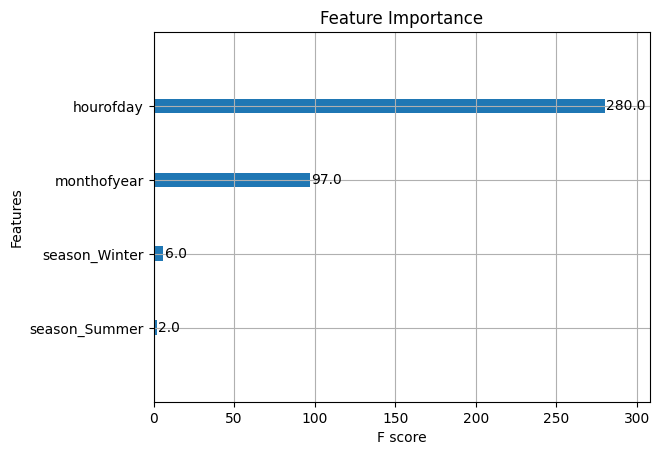

In [42]:
xgb.plot_importance(clf, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()